# 1. import library

In [2]:
import pandas as pd
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import feature_selection
import sklearn
from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
from ivis import Ivis
import os

import plotly
import plotly.graph_objs as go
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# 2.  import dataset

In [3]:
df = pd.read_csv("online_shoppers_intention.csv")
df_default = pd.read_csv("online_shoppers_intention.csv")

# 3. we find the categorical and numerical Features 

#### ce graphique represente l'echelle de variabilité des valeurs de chaque variable

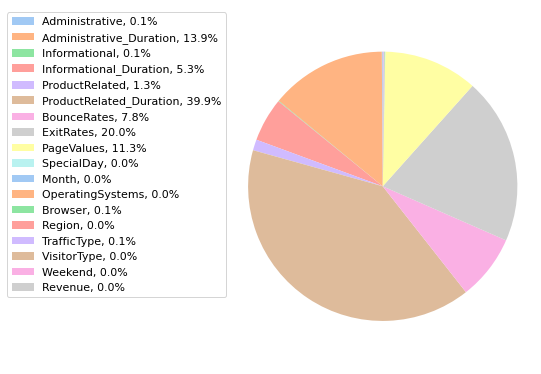

In [4]:
labels_count_columns = {}
for name in df.columns.to_list():
    labels_count_columns[name] = len(set(df[name]))
    

sizes = list(labels_count_columns.values())
labels = list(labels_count_columns.keys())

fig1, ax1 = plt.subplots(figsize=(6, 5))
fig1.subplots_adjust(0.3,0,1,1)


theme = plt.get_cmap('bwr')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])


#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(list(labels_count_columns.keys()))]

_, _ = ax1.pie(sizes, startangle=90, colors = colors)

ax1.axis('equal')

total = sum(sizes)
plt.legend(
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels, sizes)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1)
)



### ce graphique represente la proportion de valeurs de la variable cible 

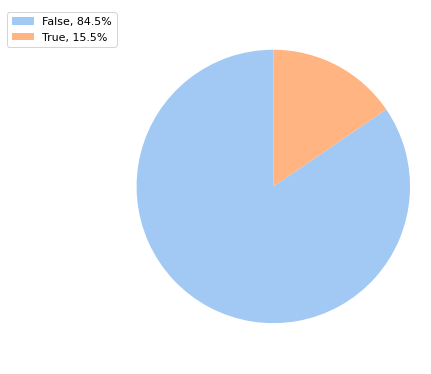

In [5]:
data_double = dict([(n, list(df["Revenue"].values).count(n)) for n in set(list(df["Revenue"].values))])
sizes_ = list(data_double.values())
labels_ = list(data_double.keys())

figRevenu, ax1 = plt.subplots(figsize=(6, 5))
figRevenu.subplots_adjust(0.3,0,1,1)


theme = plt.get_cmap('bwr')
ax1.set_prop_cycle("color", [theme(1. * i / len(sizes_)) for i in range(len(sizes_))])


#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:len(list(labels_count_columns.keys()))]

_, _ = ax1.pie(sizes_, startangle=90, colors = colors)

ax1.axis('equal')

total = sum(sizes_)
plt.legend(
    labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100) for l, s in zip(labels_, sizes_)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1)
)

## je dissocie les varaibles discretes des variables continues

In [6]:


total = sum(sizes)
categorical_feature= []
numerical_feature= []
categorical_feature = [l for l, s in zip(labels, sizes) if (float(s) / total) * 100 <1.4 and l not in ['Administrative', 'Informational', 'ProductRelated']]
numerical_feature = list(filter(lambda x : x not in categorical_feature, labels))

print(len(categorical_feature), " =>", categorical_feature)
print(len(numerical_feature), " =>", numerical_feature)

9  => ['SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Revenue']
9  => ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']


## le résultat est plutôt logique et correspond à la description des caractéristiques de l'ensemble de données

##  pour effectuer des opérations de calcul, nous devons transformer les variables catégorielles en variables numériques, pour cela nous utiliserons label encoder de sklearn

In [7]:
le = preprocessing.LabelEncoder()
for name in categorical_feature:
    df[name] = le.fit_transform(df[name].to_list())+1
    
df_analyse = df.copy()

# 5. feature engineering
## le résultat est plutôt logique et correspond à la description des caractéristiques de l'ensemble de données

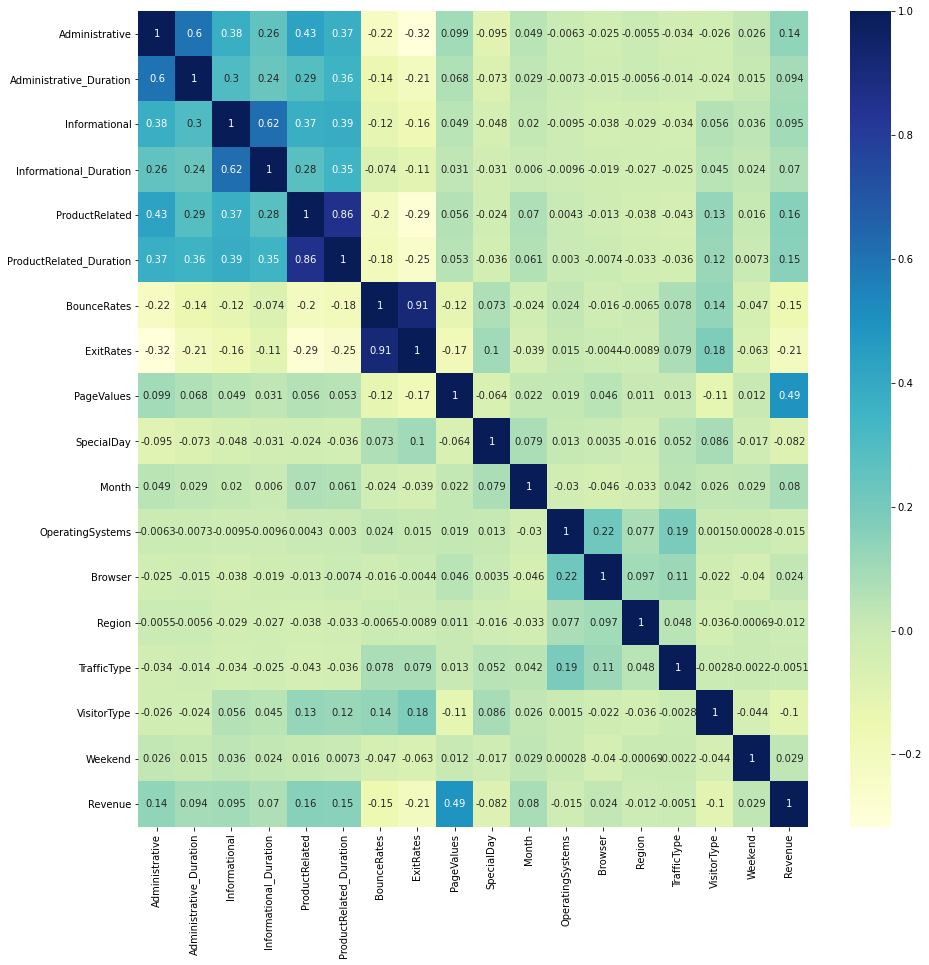

In [9]:
y = df["Revenue"]
fig, ax = plt.subplots(figsize=(15,15)) 

# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, ax=ax)
  

[('ProductRelated', 'ProductRelated_Duration'), ('ProductRelated_Duration', 'ProductRelated'), ('BounceRates', 'ExitRates'), ('ExitRates', 'BounceRates')]


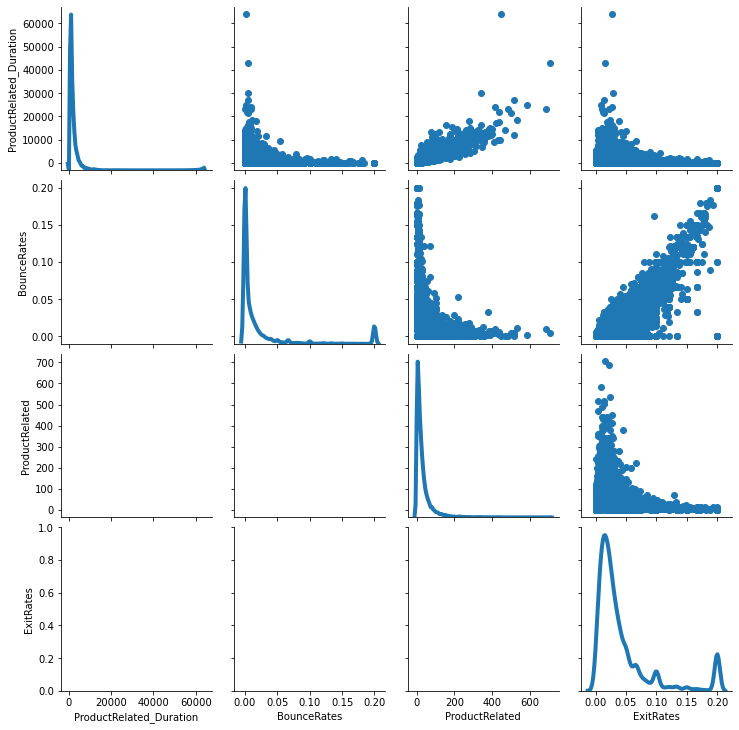

In [10]:
seuil = 0.65
orr=df.corr()
tuple_corr = []

for name in labels:
    for k,v in orr[name].to_dict().items():
        if v>seuil and name!=k:
            tuple_corr.append((name, k))
            

print(tuple_corr)
tuple_corr = list(set([y for item in tuple_corr for y in item]))

g = sns.PairGrid(df.loc[:,tuple_corr], diag_sharey=False)
#g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=len(tuple_corr))

## Ce graphique nous montre que grâce à la forte corrélation entre certaines variables, il est possible d'effectuer des régressions linéaires pour la prédiction des valeurs, ce qui est très utile lorsque nous avons des informations manquantes.

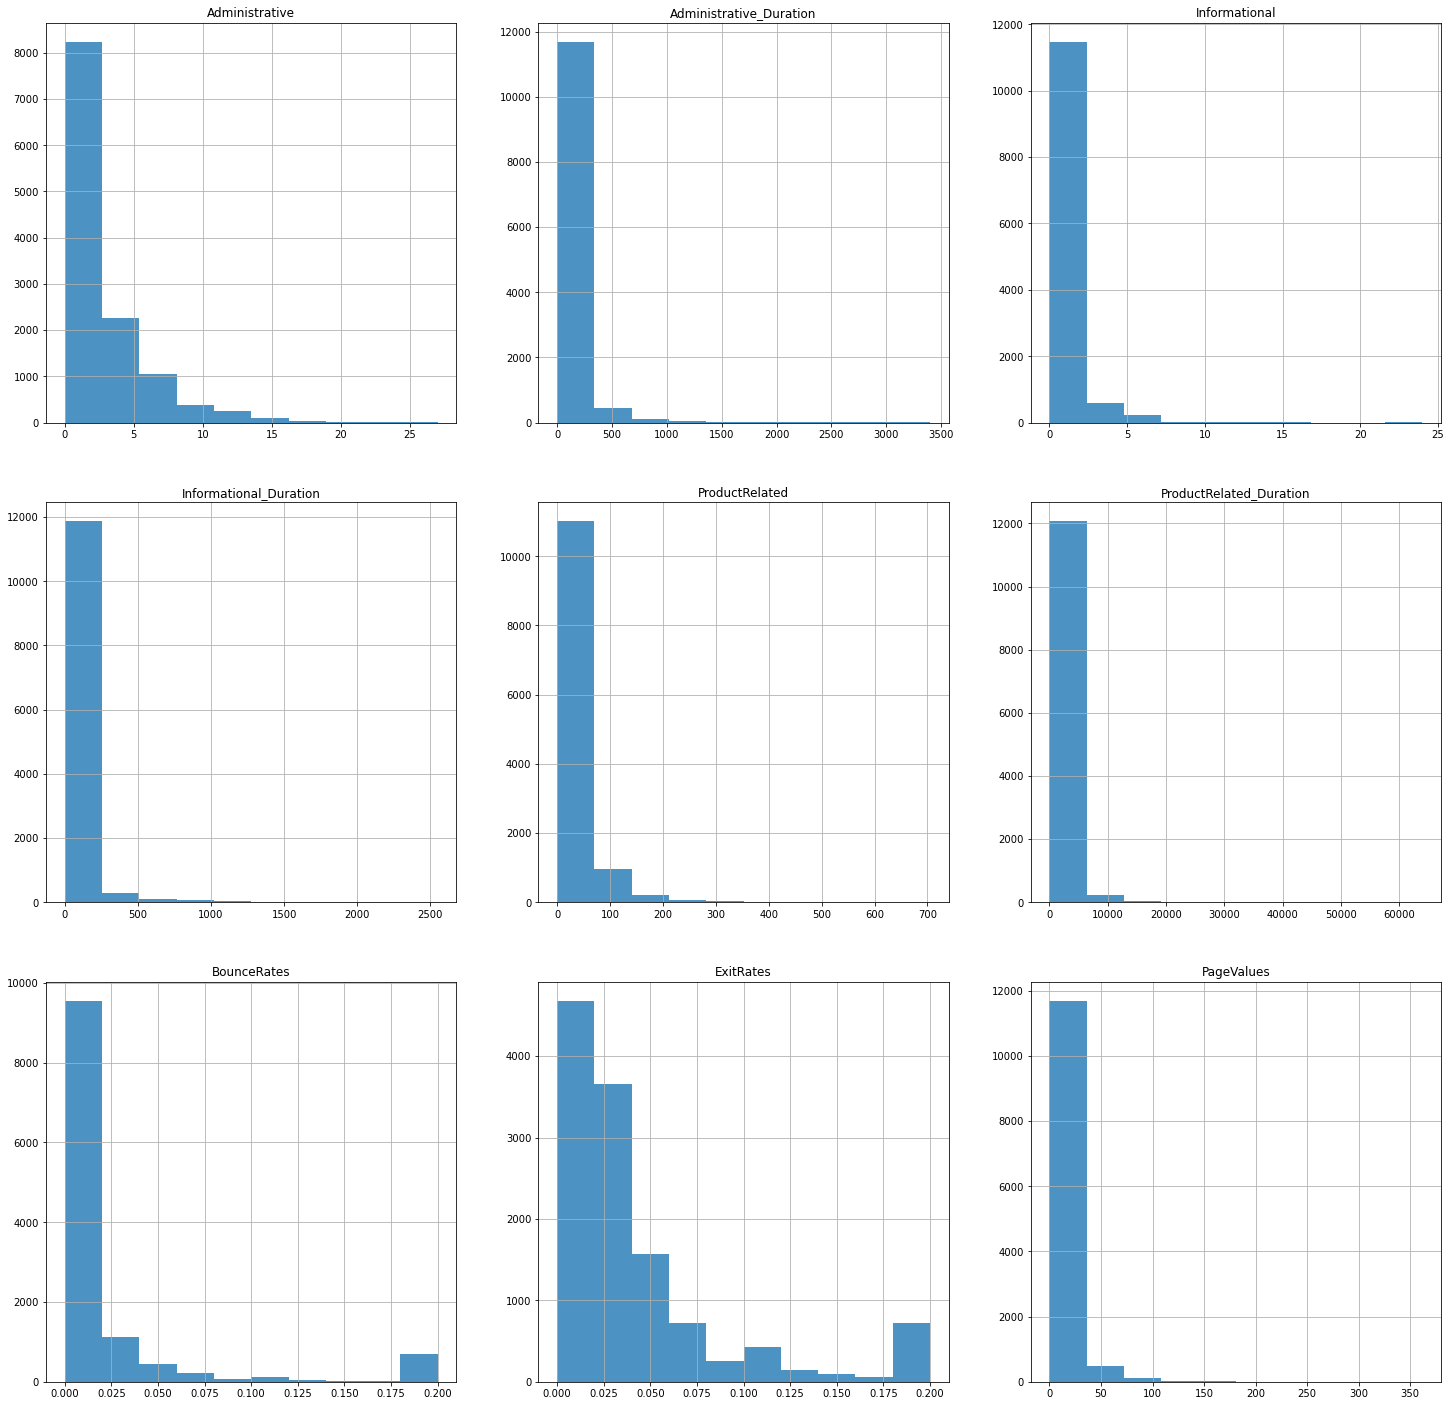

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(25, 25))
var = ""
varsx = numerical_feature.copy()
for i in range(3):
    for j in range(3):
        if var in varsx:
            varsx.remove(var)
        if varsx:
            df[varsx[0]].hist(ax=axs[i, j], alpha=0.8)
            axs[i, j].set_title(varsx[0])
            var = varsx[0]

## Grâce à ce graphique, nous pouvons conclure que toutes les caractéristiques numériques de notre jeu de données suivent une distribution asymétrique, ce qui nous permet de choisir quelle transformation nous allons appliquer à ces données pour les ramener à la même échelle, afin d'améliorer la précision de nos modèles.

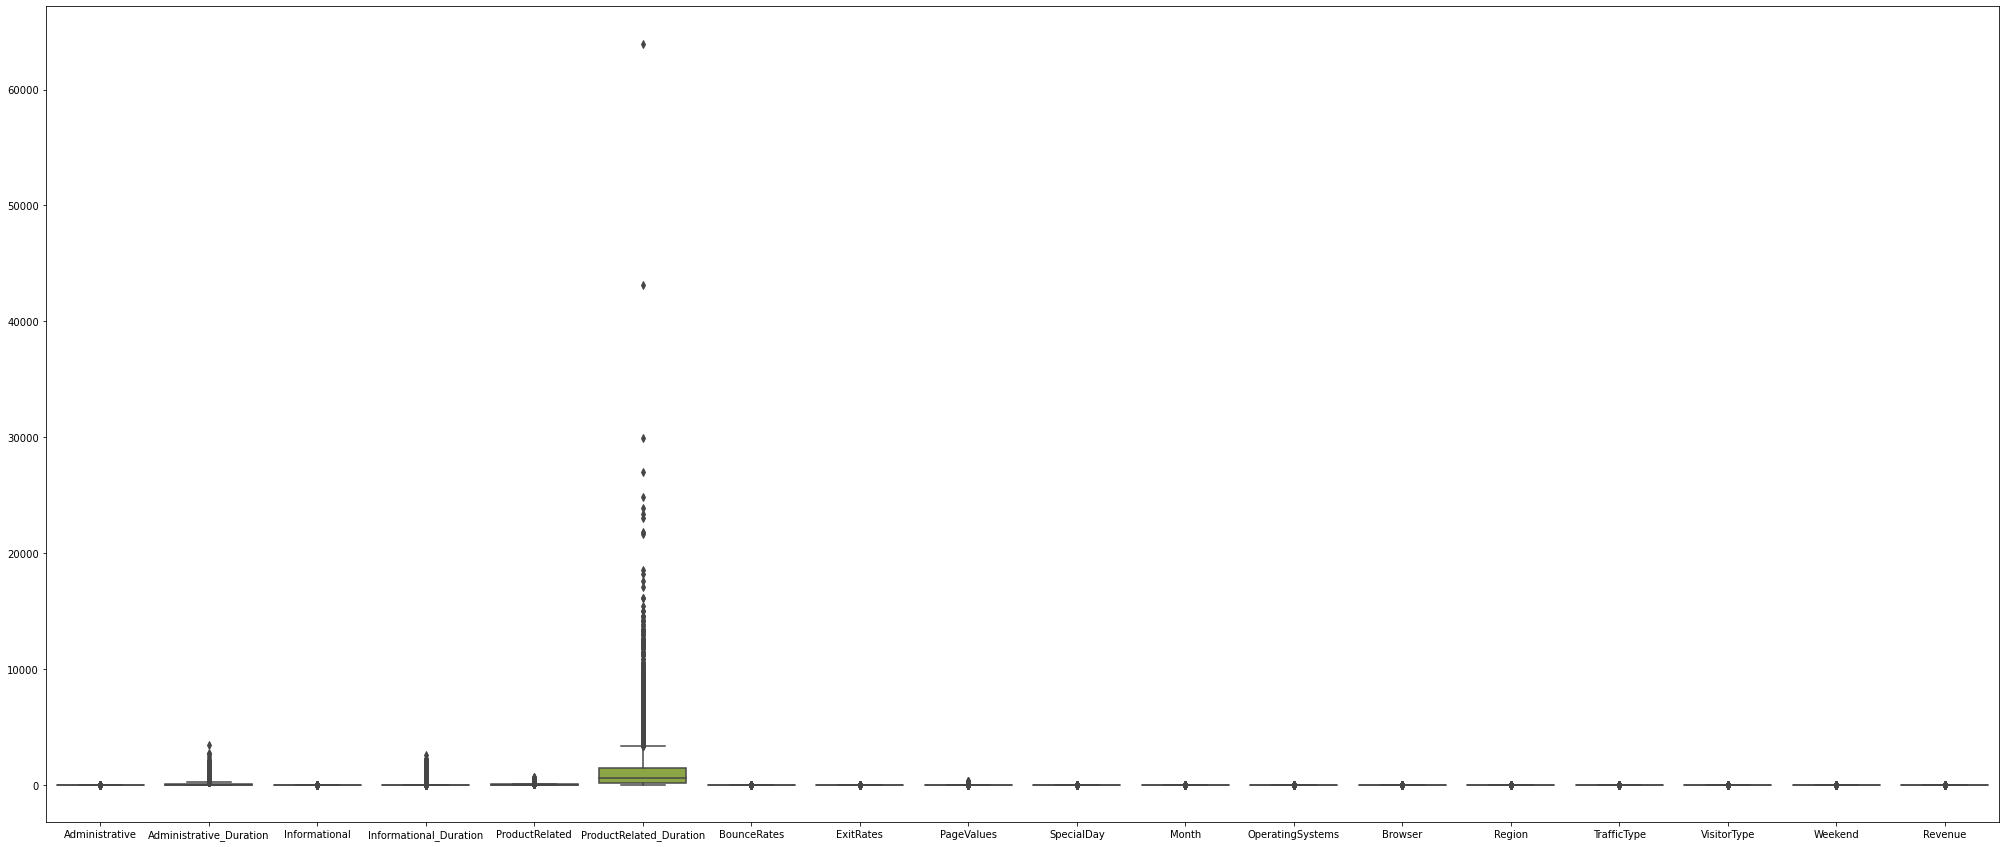

In [12]:
plt.figure(figsize=(35,15))
sns.boxplot(data=df)

## This boxplot explains a large difference in the scale margin between the variables. We will reduce them to the same scale using a log transformation for the skewed distributions and a scale transformation for the rest of the features.

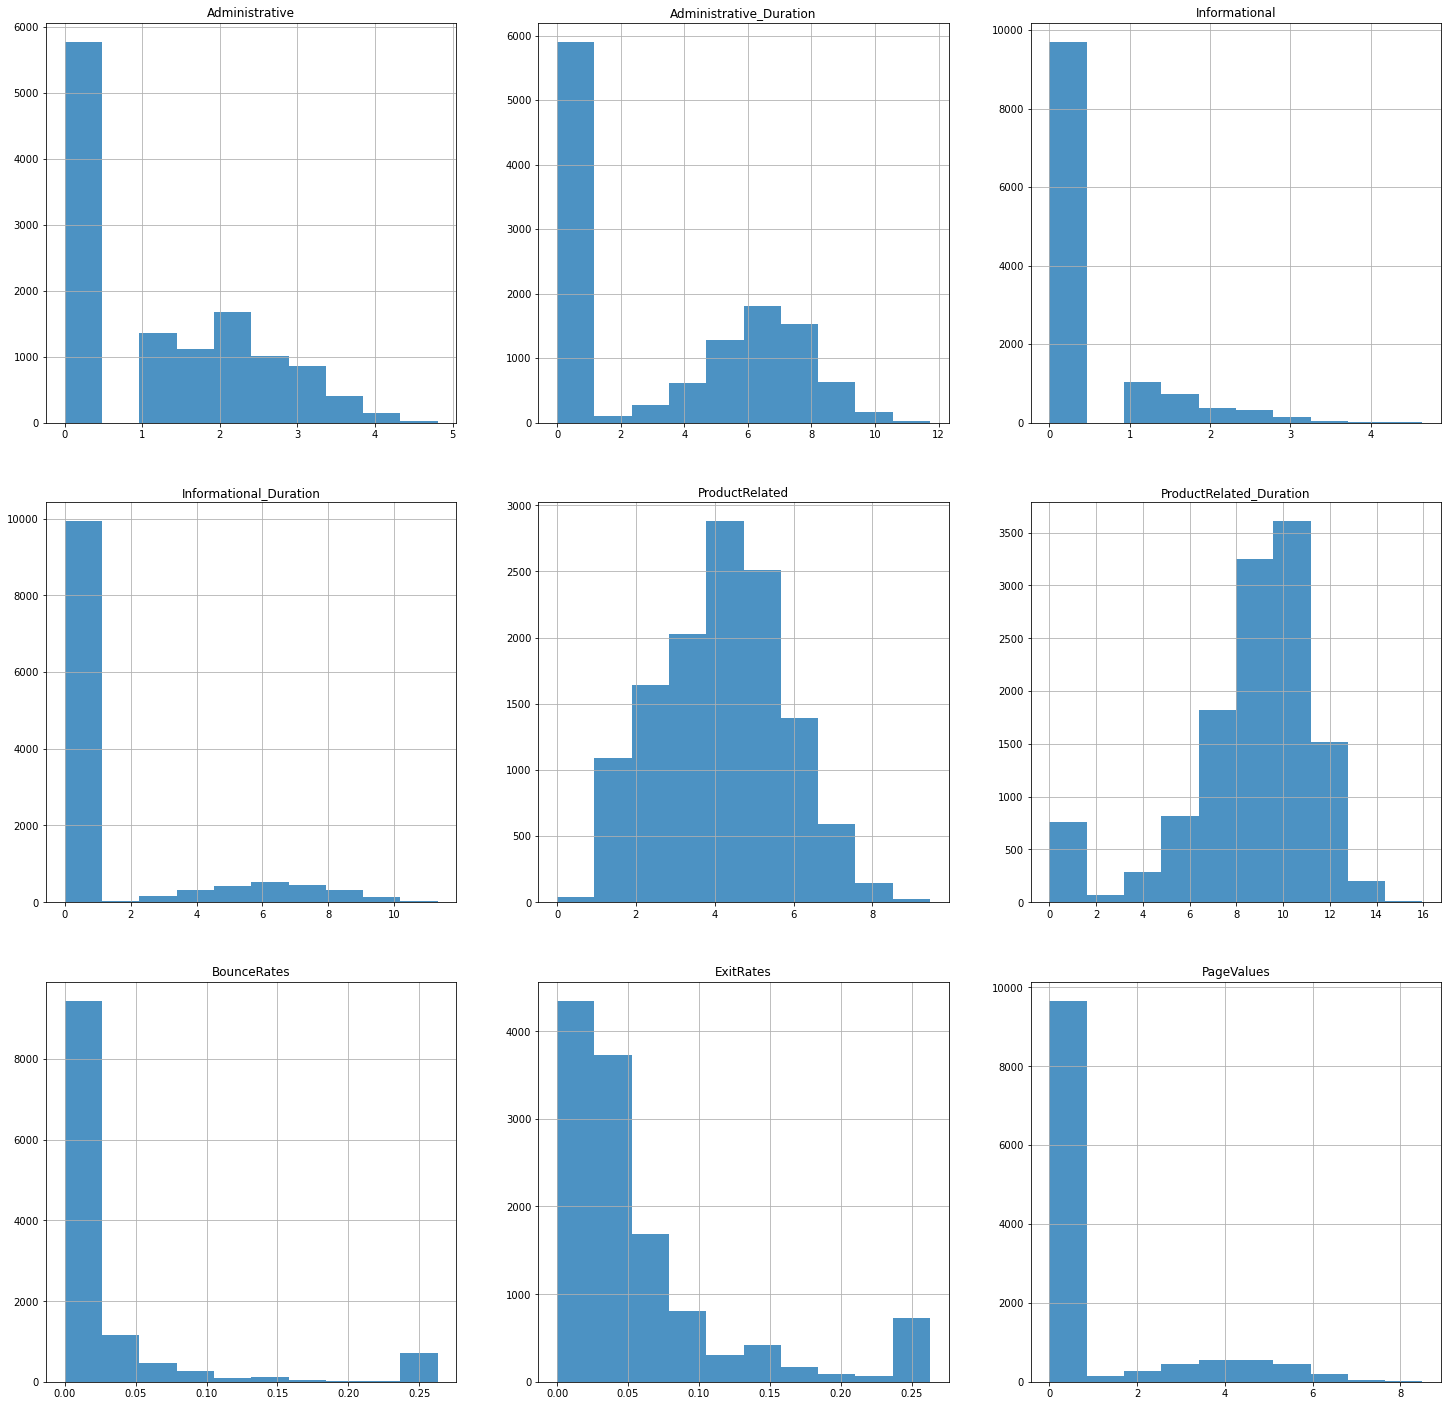

In [13]:
#df.loc[:,numerical_feature]
# Initialise the Scaler
scaler = StandardScaler()
df.loc[:,categorical_feature] = preprocessing.StandardScaler().fit_transform(df.loc[:,categorical_feature])
df.loc[:,numerical_feature] = np.log2(df.loc[:,numerical_feature]+1) 

fig, axs = plt.subplots(3, 3, figsize=(25, 25))
var = ""
varsx = numerical_feature.copy()
for i in range(3):
    for j in range(3):
        if var in varsx:
            varsx.remove(var)
        if varsx:
            df[varsx[0]].hist(ax=axs[i, j], alpha=0.8)
            axs[i, j].set_title(varsx[0])
            var = varsx[0]


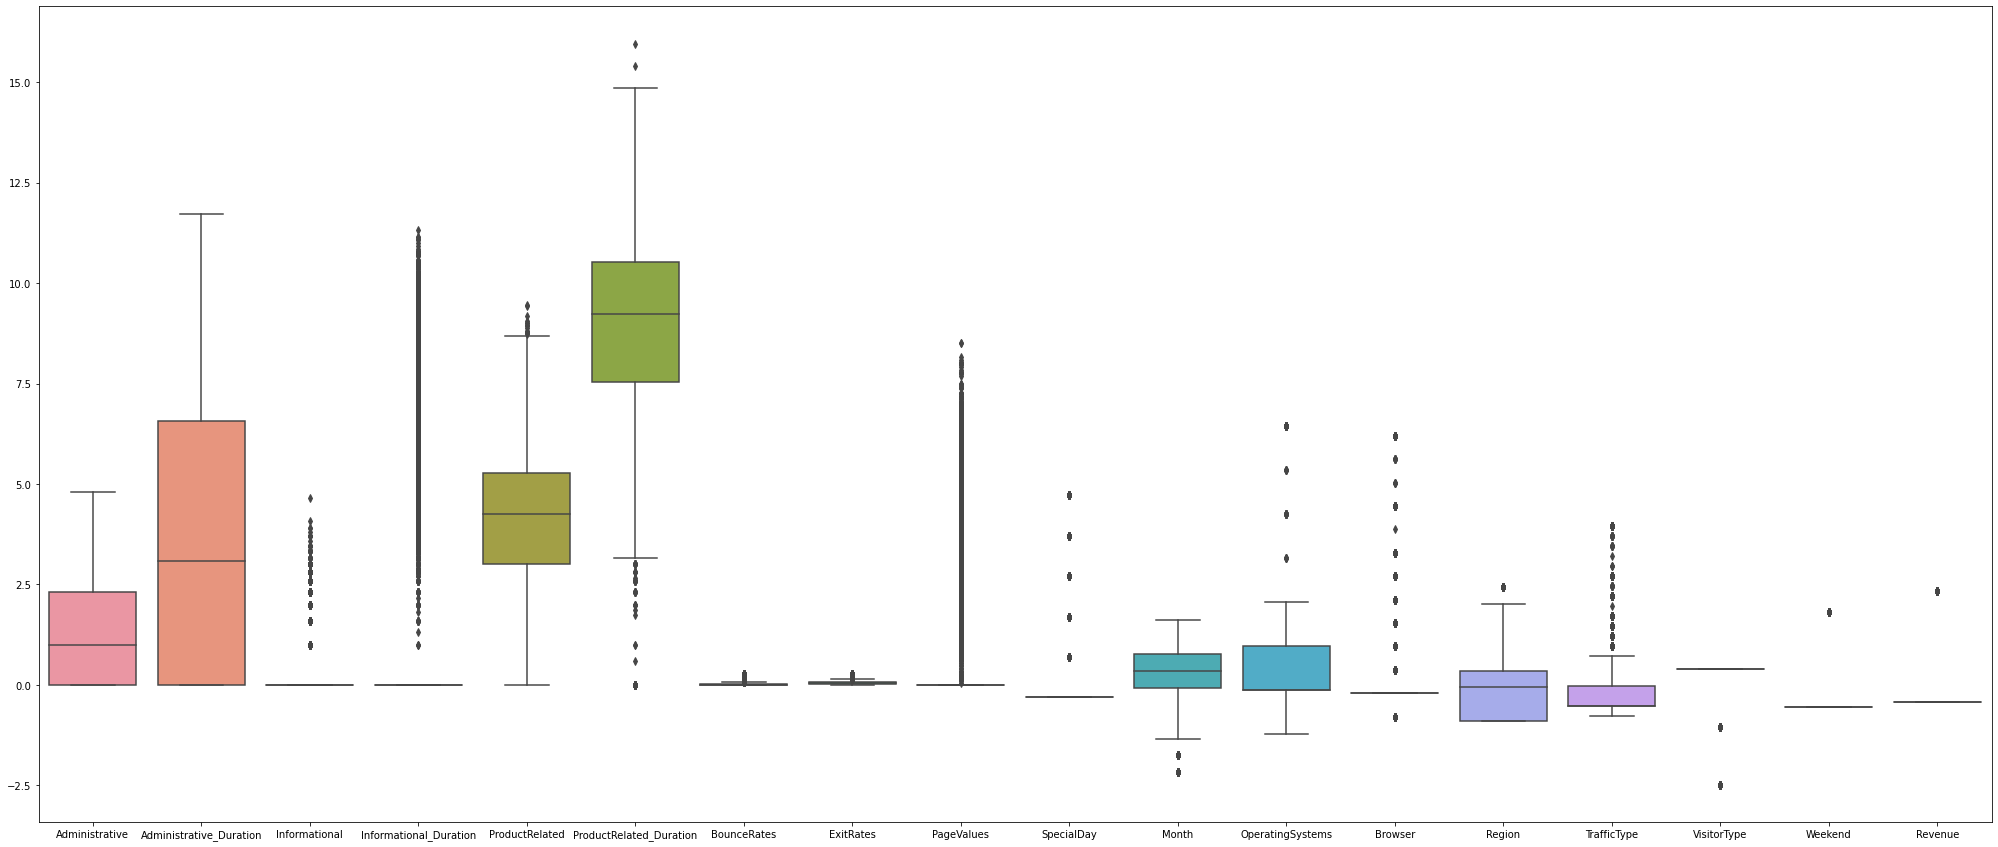

In [14]:
plt.figure(figsize=(35,15))
sns.boxplot(data=df)

# separate dataframe

In [15]:
df["Revenue"] = y-1
train_dataframe=df.sample(frac=0.8,random_state=200) #random state is a seed value
valid_dataframe=df.drop(train_dataframe.index)

In [16]:
train_train_dataframe=train_dataframe.sample(frac=0.8,random_state=200) #random state is a seed value
test_train_dataframe=df.drop(train_train_dataframe.index)

y_train, x_train =train_train_dataframe["Revenue"], train_train_dataframe.loc[:, train_train_dataframe.columns != 'Revenue']
y_test, x_test =test_train_dataframe["Revenue"], test_train_dataframe.loc[:, test_train_dataframe.columns != 'Revenue']
y_valid, x_valid =valid_dataframe["Revenue"], valid_dataframe.loc[:, valid_dataframe.columns != 'Revenue']

# Numerical Feature Selection

here are two popular feature selection techniques that can be used for numerical input data and a categorical (class) target variable.

They are:

ANOVA-f Statistic.
Mutual Information Statistics.
Let’s take a closer look at each in turn.

### ANOVA f-test Feature Selection and mutable

In [17]:
def select_feature(x_train, y_train,x_test,k='all',method = 'anova',graphic = True):
    # configure to select all features
    fs= None
    if method == "anova":
        fs = feature_selection.SelectKBest(score_func=feature_selection.f_classif, k=k)
    else:
        fs = feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=k)
    # learn relationship from training data
    fs.fit(x_train, y_train)
    # transform train input data
    x_train_fs = fs.transform(x_train)
    x_test_fs = fs.transform(x_test)
    
    # what are scores for the features
    if graphic:
        i = 0
        for nm in x_train.columns:
            print('Feature %s: %f' % (nm, fs.scores_[i]))
            i = i+1
        # plot the scores
        plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
        plt.show()
    
    return x_train_fs, x_test_fs, fs

# Select best feature with logistic regression

In [18]:
def calculate_score(k, x_train, y_train, x_test, y_test):
    plt.figure(figsize=(35,15))
    x_train_fs_anova, x_test_fs_anova, fs_anova = select_feature(x_train, y_train,x_test,k=k,method = 'anova',graphic = False)
    plt.figure(figsize=(35,15))
    x_train_fs_mutable, x_test_fs_mutable, fs_mutable = select_feature(x_train, y_train,x_test,k=k,method = 'mutable',graphic = False)

    ## anova
    # fit the model
    model_anova = LogisticRegression(solver='liblinear')
    model_anova.fit(x_train_fs_anova, y_train)
    # evaluate the model
    yhat = model_anova.predict(x_test_fs_anova)
    # evaluate predictions
    accuracy_ = accuracy_score(y_test, yhat)

    model_mutate = LogisticRegression(solver='liblinear')
    model_mutate.fit(x_train_fs_mutable, y_train)
    # evaluate the model
    yhat = model_mutate.predict(x_test_fs_mutable)
    # evaluate predictions
    accuracy = accuracy_score(y_test, yhat)

    return accuracy_*100, accuracy*100

In [19]:
listt = list(range(1,len(x_train.columns)))
listt.append("all")
scores = {k : calculate_score(k,x_train, y_train, x_test, y_test) for k in listt}

<ipython-input-18-ecf2adfda9bd>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(35,15))
<ipython-input-18-ecf2adfda9bd>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(35,15))
<ipython-input-18-ecf2adfda9bd>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(35,15)

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

<Figure size 2520x1080 with 0 Axes>

In [20]:
df_score = pd.DataFrame({"k" : list(scores.keys()), "anova" : [n[0] for n in list(scores.values())], "mutable" : [n[1] for n in list(scores.values())]})  
df_score

k      anova    mutable
0     1  89.254337  89.254337
1     2  89.366975  89.366975
2     3  89.254337  89.299392
3     4  89.254337  89.276864
4     5  89.231809  89.366975
5     6  89.209281  89.119171
6     7  89.321919  89.209281
7     8  89.276864  89.727416
8     9  89.344447  89.862582
9    10  89.366975  89.817526
10   11  89.840054  89.704888
11   12  89.885109  89.749944
12   13  89.772471  89.704888
13   14  89.772471  89.817526
14   15  89.840054  89.840054
15   16  89.862582  89.817526
16  all  89.749944  89.749944

### en utilisant anova ,avec k =12 qui correspond au nombre de variables choisi, nous avons un très bon resultat de prédiction

Feature Administrative: 205.188876
Feature Administrative_Duration: 204.494243
Feature Informational: 93.739748
Feature Informational_Duration: 104.824051
Feature ProductRelated: 332.992125
Feature ProductRelated_Duration: 324.414327
Feature BounceRates: 190.484680
Feature ExitRates: 367.568809
Feature PageValues: 5013.200929
Feature SpecialDay: 44.213525
Feature Month: 51.849511
Feature OperatingSystems: 1.702282
Feature Browser: 7.327769
Feature Region: 0.242097
Feature TrafficType: 0.067861
Feature VisitorType: 77.688841
Feature Weekend: 9.010779


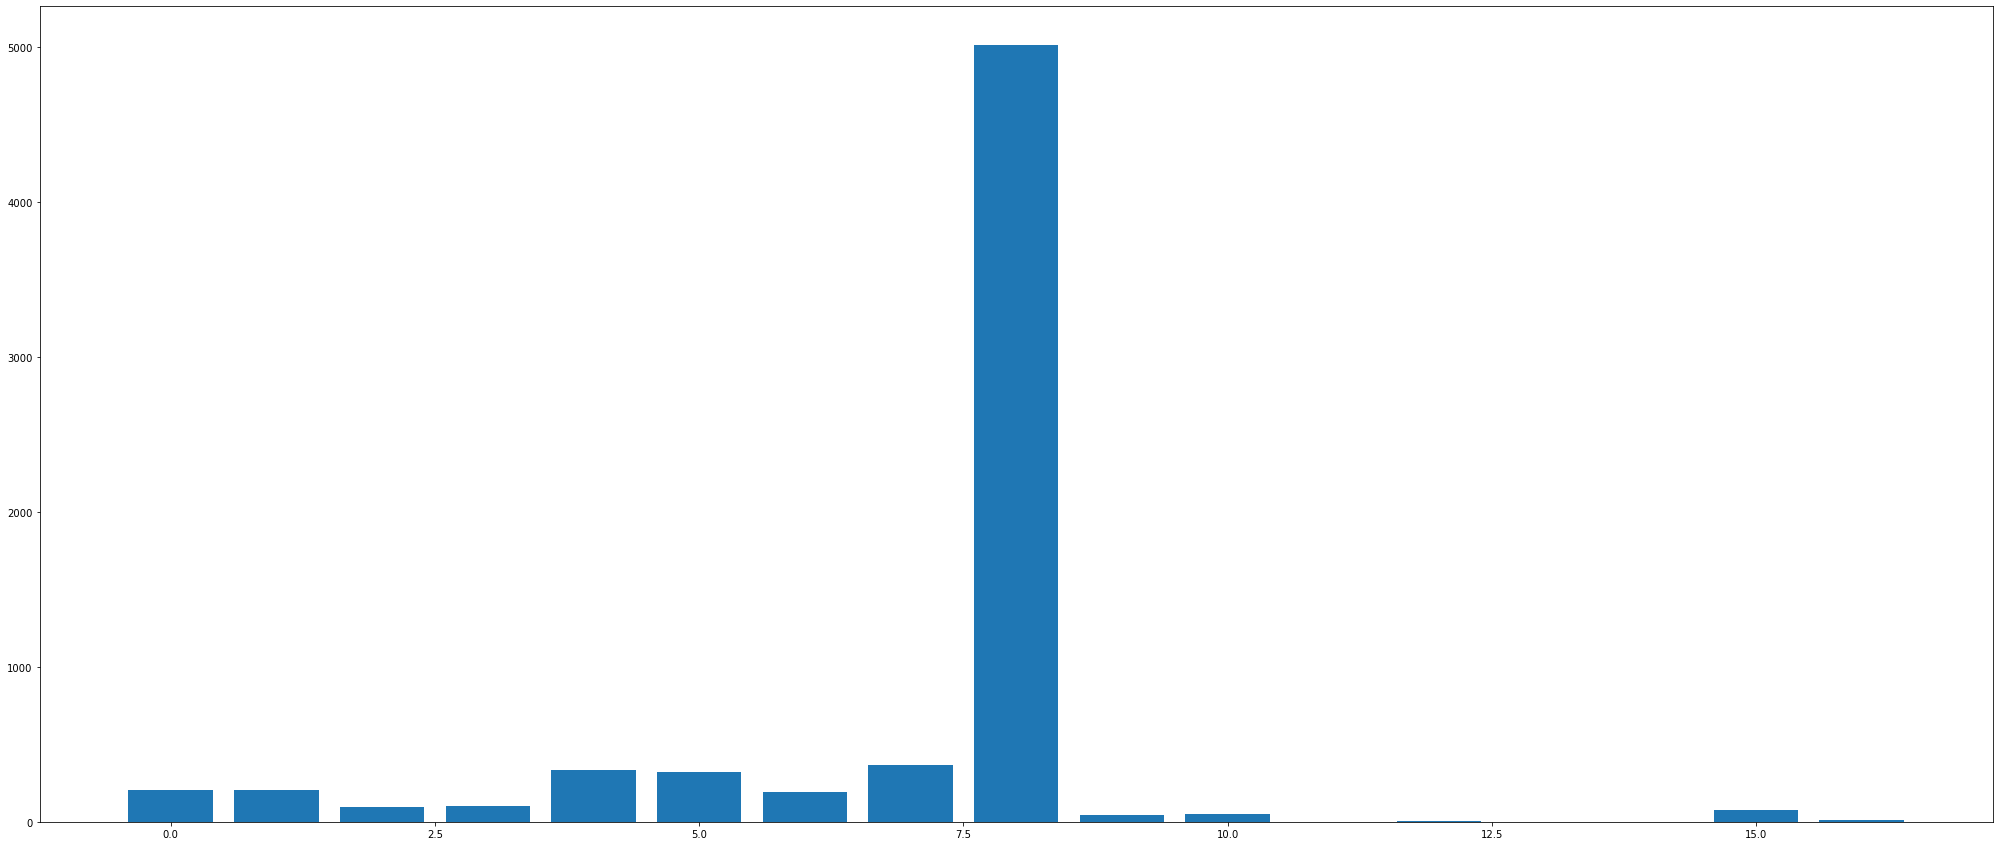

score:  89.88510925884208


In [22]:
plt.figure(figsize=(35,15))
x_train_fs_anova, x_test_fs_anova, fs_anova = select_feature(x_train, y_train,x_test,k=12,method = 'anova',graphic = True)
# fit the model
model_anova = LogisticRegression(solver='liblinear')
model_anova.fit(x_train_fs_anova, y_train)
# evaluate the model
yhat = model_anova.predict(x_test_fs_anova)
# evaluate predictions
accuracy_ = accuracy_score(y_test, yhat)
print("score: ",accuracy_*100)

##  interprétation des valeurs

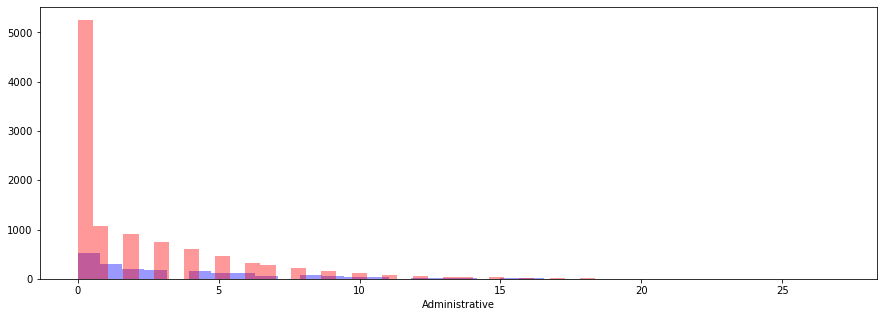

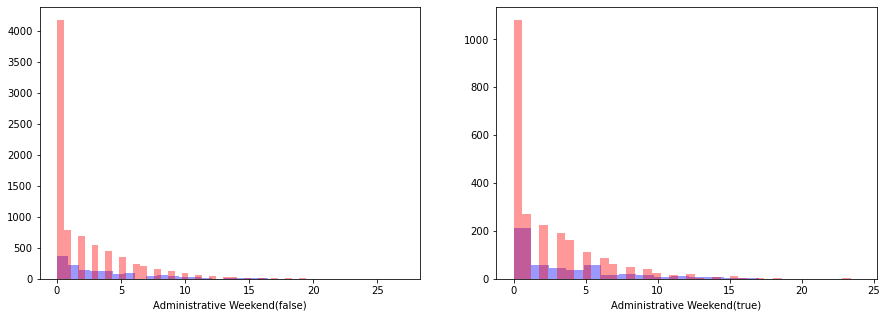

In [23]:
total_revenue = df_analyse[df_analyse['Revenue']==2]
total_not_revenue = df_analyse[df_analyse['Revenue']==1]
weekend_true = df_analyse[(df_analyse['Revenue']==2) & (df_analyse['Weekend']==2)]
weekend_false = df_analyse[(df_analyse['Revenue']==2) & (df_analyse['Weekend']==1)]
weekend_true_not_survived =  df_analyse[(df_analyse['Revenue']==1) & (df_analyse['Weekend']==2)]
weekend_false_not_survived = df_analyse[(df_analyse['Revenue']==1) & (df_analyse['Weekend']==1)]

plt.figure(figsize=[15,5])
plt.subplot(111)
sns.distplot(total_revenue['Administrative'].dropna().values, kde=False, color='blue')
sns.distplot(total_not_revenue['Administrative'].dropna().values,  kde=False, color='red', axlabel='Administrative')

plt.figure(figsize=[15,5])

plt.subplot(121)
sns.distplot(weekend_false['Administrative'].dropna().values, kde=False, color='blue')
sns.distplot(weekend_false_not_survived['Administrative'].dropna().values, kde=False, color='red', axlabel='Administrative Weekend(false)')

plt.subplot(122)
sns.distplot(weekend_true['Administrative'].dropna().values,  kde=False, color='blue')
sns.distplot(weekend_true_not_survived['Administrative'].dropna().values,  kde=False, color='red', axlabel='Administrative Weekend(true)')

D'après les chiffres ci-dessus, nous pouvons constater que :

En combinant le Vrai et le Faux administratif, les pages de type administratif sont majoritairement visitées une seule fois et ne donnent généralement pas lieu à un achat.

les pages de type administratif sont beaucoup plus visitées les jours ouvrables, c'est-à-dire du lundi au vendredi, mais n'influencent pas la décision d'achat qui est généralement abandonnée.

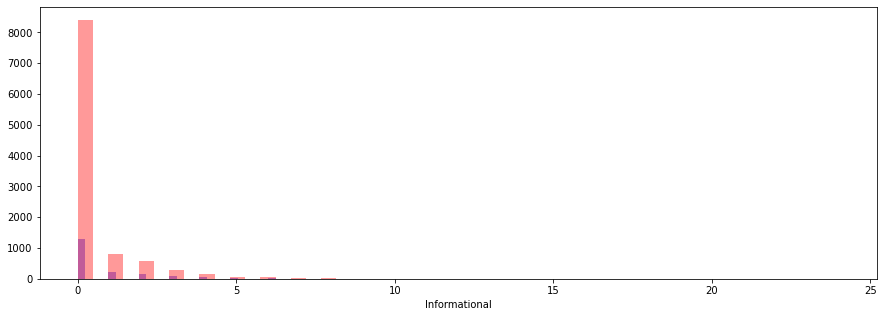

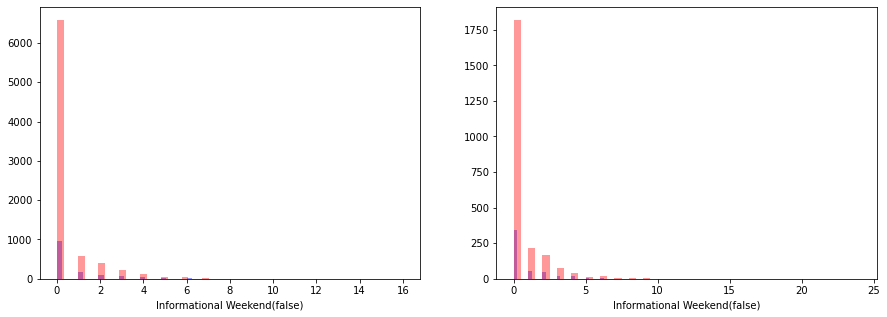

In [24]:
total_revenue = df_analyse[df_analyse['Revenue']==2]
total_not_revenue = df_analyse[df_analyse['Revenue']==1]
weekend_true = df_analyse[(df_analyse['Revenue']==2) & (df_analyse['Weekend']==2)]
weekend_false = df_analyse[(df_analyse['Revenue']==2) & (df_analyse['Weekend']==1)]
weekend_true_not_survived =  df_analyse[(df_analyse['Revenue']==1) & (df_analyse['Weekend']==2)]
weekend_false_not_survived = df_analyse[(df_analyse['Revenue']==1) & (df_analyse['Weekend']==1)]

plt.figure(figsize=[15,5])
plt.subplot(111)
sns.distplot(total_revenue['Informational'].dropna().values, kde=False, color='blue')
sns.distplot(total_not_revenue['Informational'].dropna().values,  kde=False, color='red', axlabel='Informational')

plt.figure(figsize=[15,5])

plt.subplot(121)
sns.distplot(weekend_false['Informational'].dropna().values, kde=False, color='blue')
sns.distplot(weekend_false_not_survived['Informational'].dropna().values, kde=False, color='red', axlabel='Informational Weekend(false)')

plt.subplot(122)
sns.distplot(weekend_true['Informational'].dropna().values,  kde=False, color='blue')
sns.distplot(weekend_true_not_survived['Informational'].dropna().values,  kde=False, color='red', axlabel='Informational Weekend(false)')

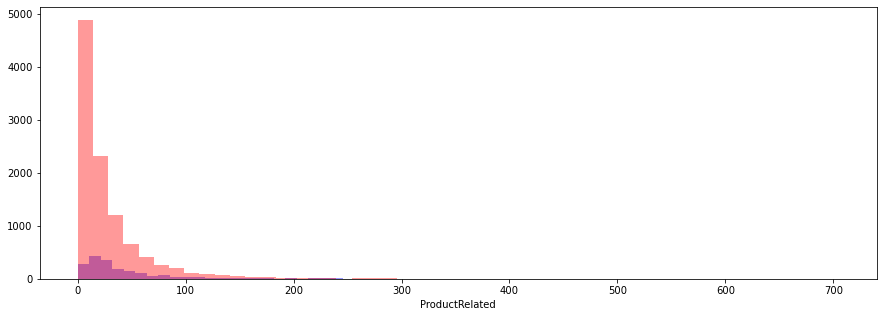

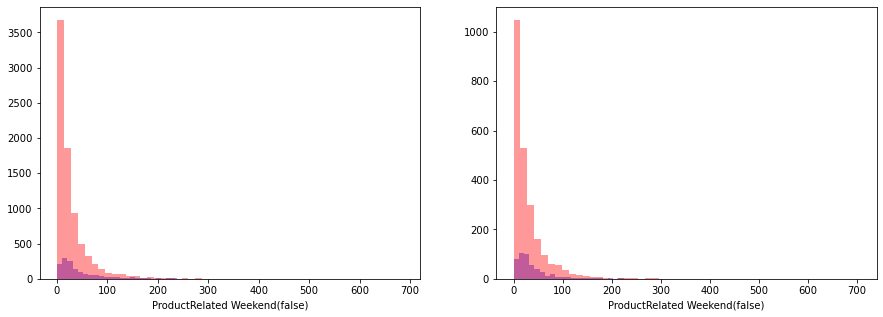

In [25]:
total_revenue = df_analyse[df_analyse['Revenue']==2]
total_not_revenue = df_analyse[df_analyse['Revenue']==1]
weekend_true = df_analyse[(df_analyse['Revenue']==2) & (df_analyse['Weekend']==2)]
weekend_false = df_analyse[(df_analyse['Revenue']==2) & (df_analyse['Weekend']==1)]
weekend_true_not_survived =  df_analyse[(df_analyse['Revenue']==1) & (df_analyse['Weekend']==2)]
weekend_false_not_survived = df_analyse[(df_analyse['Revenue']==1) & (df_analyse['Weekend']==1)]

plt.figure(figsize=[15,5])
plt.subplot(111)
sns.distplot(total_revenue['ProductRelated'].dropna().values, kde=False, color='blue')
sns.distplot(total_not_revenue['ProductRelated'].dropna().values,  kde=False, color='red', axlabel='ProductRelated')

plt.figure(figsize=[15,5])

plt.subplot(121)
sns.distplot(weekend_false['ProductRelated'].dropna().values, kde=False, color='blue')
sns.distplot(weekend_false_not_survived['ProductRelated'].dropna().values, kde=False, color='red', axlabel='ProductRelated Weekend(false)')

plt.subplot(122)
sns.distplot(weekend_true['ProductRelated'].dropna().values,  kde=False, color='blue')
sns.distplot(weekend_true_not_survived['ProductRelated'].dropna().values,  kde=False, color='red', axlabel='ProductRelated Weekend(false)')

Ce graphique nous permet de conclure que les pages relatives aux produits sont beaucoup plus consultées mais n'influencent pas la décision d'achat selon le week-end ou non.

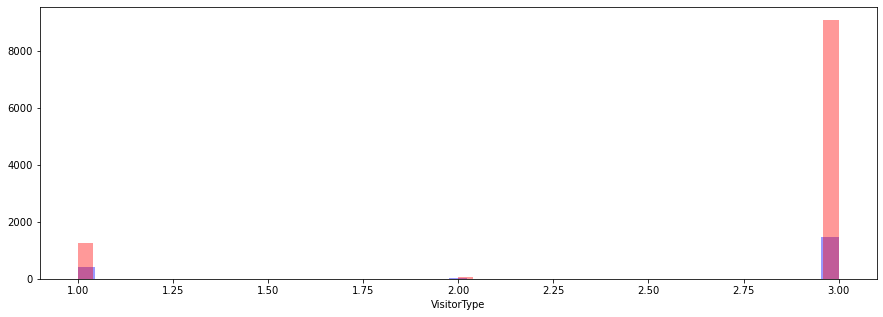

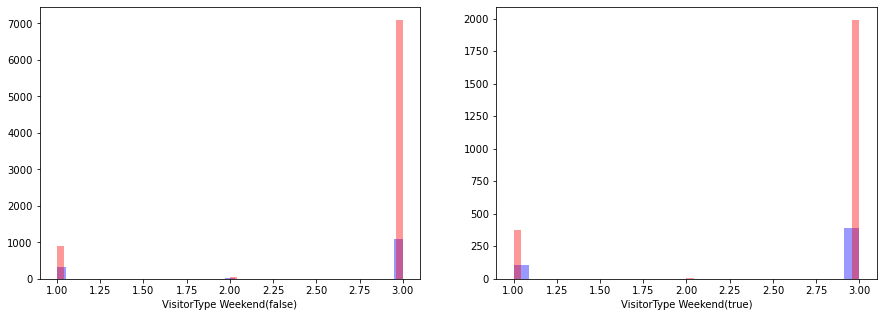

In [26]:
total_revenue = df_analyse[df_analyse['Revenue']==2]
total_not_revenue = df_analyse[df_analyse['Revenue']==1]
weekend_true = df_analyse[(df_analyse['Revenue']==2) & (df_analyse['Weekend']==2)]
weekend_false = df_analyse[(df_analyse['Revenue']==2) & (df_analyse['Weekend']==1)]
weekend_true_not_survived =  df_analyse[(df_analyse['Revenue']==1) & (df_analyse['Weekend']==2)]
weekend_false_not_survived = df_analyse[(df_analyse['Revenue']==1) & (df_analyse['Weekend']==1)]

plt.figure(figsize=[15,5])
plt.subplot(111)
sns.distplot(total_revenue['VisitorType'].dropna().values, kde=False, color='blue')
sns.distplot(total_not_revenue['VisitorType'].dropna().values,  kde=False, color='red', axlabel='VisitorType')

plt.figure(figsize=[15,5])

plt.subplot(121)
sns.distplot(weekend_false['VisitorType'].dropna().values, kde=False, color='blue')
sns.distplot(weekend_false_not_survived['VisitorType'].dropna().values, kde=False, color='red', axlabel='VisitorType Weekend(false)')

plt.subplot(122)
sns.distplot(weekend_true['VisitorType'].dropna().values,  kde=False, color='blue')
sns.distplot(weekend_true_not_survived['VisitorType'].dropna().values,  kde=False, color='red', axlabel='VisitorType Weekend(true)')

ce graphique nous permet de dire que le visitorType à une très grande influence sur le resultat de la decision car comme vous le voyez, le visitorType 3 à un impaque beaucoup plus important que les autres sur la décisons d'achat ou pas et le visitorType 2 à une decision d'achat favorable presque null

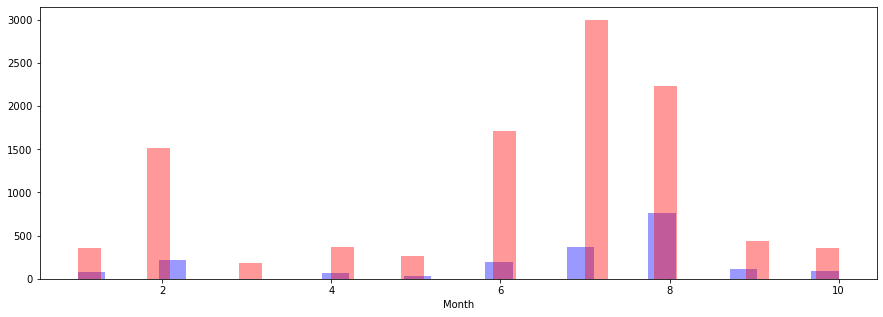

In [27]:
total_revenue = df_analyse[df_analyse['Revenue']==2]
total_not_revenue = df_analyse[df_analyse['Revenue']==1]

plt.figure(figsize=[15,5])
plt.subplot(111)
sns.distplot(total_revenue['Month'].dropna().values, kde=False, color='blue')
sns.distplot(total_not_revenue['Month'].dropna().values,  kde=False, color='red', axlabel='Month')


ce graphique nous permet de dire que le mois  à une très grande influence sur le resultat de la decision car comme vous le voyez, le mois 7 à un impaque plus important que les autres sur la décisons d'achat ou pas et le mois 3 à une decision d'achat favorable presque null

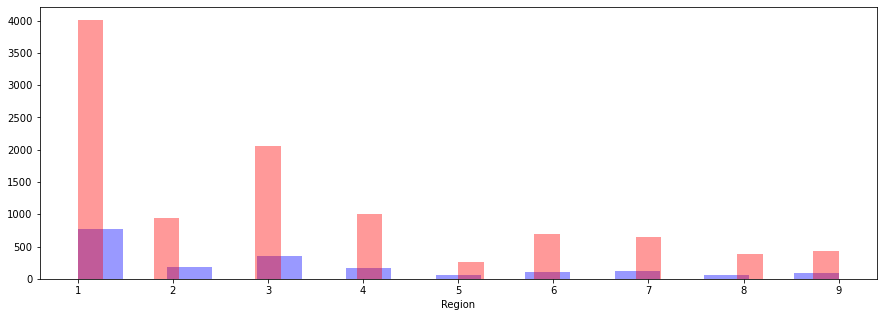

In [28]:
total_revenue = df_analyse[df_analyse['Revenue']==2]
total_not_revenue = df_analyse[df_analyse['Revenue']==1]

plt.figure(figsize=[15,5])
plt.subplot(111)
sns.distplot(total_revenue['Region'].dropna().values, kde=False, color='blue')
sns.distplot(total_not_revenue['Region'].dropna().values,  kde=False, color='red', axlabel='Region')

ce graphique nous permet de dire que la region à une très grande influence sur le resultat de la decision car comme vous le voyez, la region 1 à un impaque plus important que les autres sur la décisons d'achat ou pas et dans la region 5 il ya beaucoup moins d'activités

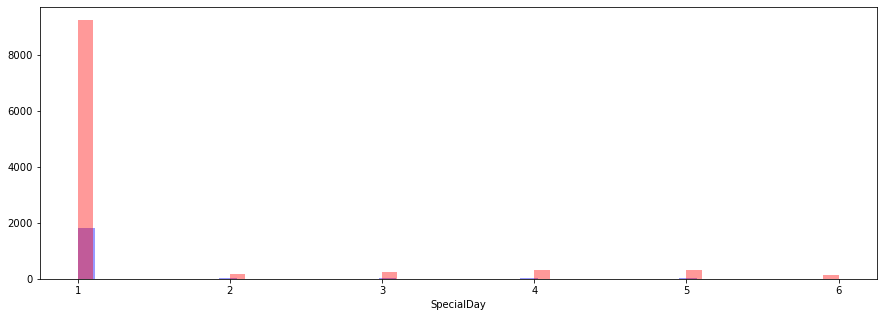

In [29]:
total_revenue = df_analyse[df_analyse['Revenue']==2]
total_not_revenue = df_analyse[df_analyse['Revenue']==1]

plt.figure(figsize=[15,5])
plt.subplot(111)
sns.distplot(total_revenue['SpecialDay'].dropna().values, kde=False, color='blue')
sns.distplot(total_not_revenue['SpecialDay'].dropna().values,  kde=False, color='red', axlabel='SpecialDay')

ce graphique nous permet de dire que le SpecialDay à une très grande influence sur le resultat de la decision car comme vous le voyez, le specialDay 1 à un impaque beaucoup plus important que les autres sur la décisons d'achat ou pas et le specialDay 6 à une decision d'achat favorable presque null

{1, 2, 3, 4, 5, 6, 7, 8}


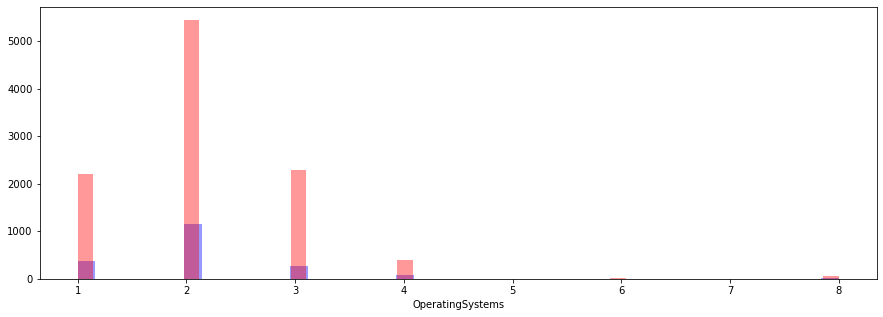

In [30]:
total_revenue = df_analyse[df_analyse['Revenue']==2]
total_not_revenue = df_analyse[df_analyse['Revenue']==1]

plt.figure(figsize=[15,5])
plt.subplot(111)
sns.distplot(total_revenue['OperatingSystems'].dropna().values, kde=False, color='blue')
sns.distplot(total_not_revenue['OperatingSystems'].dropna().values,  kde=False, color='red', axlabel='OperatingSystems')
print(set(df_default["OperatingSystems"].values))

ce graphique nous permet de dire que le operatingSystem de type 2 est beaucoup plus utilisé

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


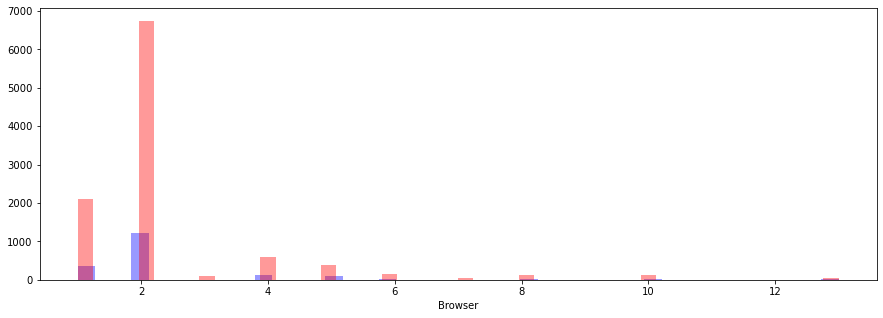

In [31]:
total_revenue = df_analyse[df_analyse['Revenue']==2]
total_not_revenue = df_analyse[df_analyse['Revenue']==1]

plt.figure(figsize=[15,5])
plt.subplot(111)
sns.distplot(total_revenue['Browser'].dropna().values, kde=False, color='blue')
sns.distplot(total_not_revenue['Browser'].dropna().values,  kde=False, color='red', axlabel='Browser')
print(set(df_default["Browser"].values))

ce graphique nous permet de dire que le browsers de type 2 est beaucoup plus utilisé, et le browser de type 13 est beaucoup moins utiliser mais garde un ratio correct entre la décision d'achat ou pas 

# visualisation global de la donnée
## Résumer
Nous allons faire une reduction de dimenssionalité de la donnée, pour effectuer une visualisation en 3d de nos donnée

In [32]:
# supression de la colinéarité
principalComponents = TruncatedSVD(n_components=len(df.loc[:, df.columns != "Revenue"].columns)-1).fit_transform(df.loc[:, df.columns != "Revenue"])

In [33]:
model = Ivis(model='maaten',n_epochs_without_progress = 5, embedding_dims = 3)
if os.path.isdir('saveModelIvis'):
    model = model.load_model("saveModelIvis")
    embdeding = model.transform(principalComponents)
if os.path.isdir('saveModelIvis')==False:
    embdeding = model.fit_transform(principalComponents,df["Revenue"].values)
    model.save_model("saveModelIvis", save_format='h5', overwrite=False)

97/97 [==============================] - 2s 1ms/step


# visualisation en 2d

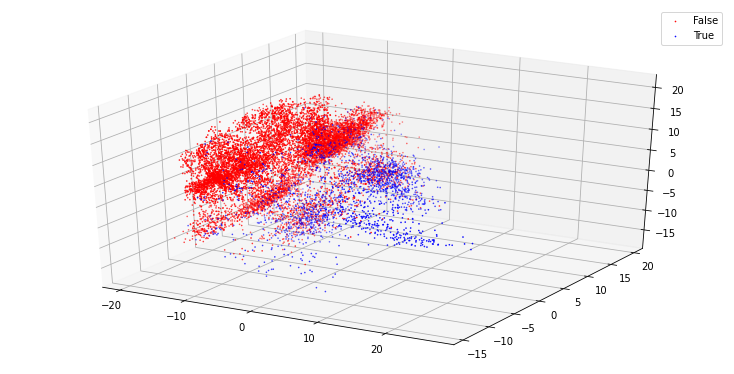

In [35]:


fig = plt.figure(figsize=[10,5])
ax = Axes3D(fig)

embdeding_false_zero = []
embdeding_true_zero = []
for i in range(len(embdeding[:,0])):
    if df["Revenue"].values[i] == 0:
        embdeding_false_zero.append(embdeding[:,0][i])
    else:
        embdeding_true_zero.append(embdeding[:,0][i])
        

embdeding_false_un = []
embdeding_true_un = []
for i in range(len(embdeding[:,1])):
    if df["Revenue"].values[i] == 0:
        embdeding_false_un.append(embdeding[:,1][i])
    else:
        embdeding_true_un.append(embdeding[:,1][i])
        
        
embdeding_false_deux = []
embdeding_true_deux = []
for i in range(len(embdeding[:,2])):
    if df["Revenue"].values[i] == 0:
        embdeding_false_deux.append(embdeding[:,2][i])
    else:
        embdeding_true_deux.append(embdeding[:,2][i])

        
ax.scatter(embdeding_false_zero, embdeding_false_un,embdeding_false_deux,label='False',s = 0.4, c = "red")
ax.scatter(embdeding_true_zero, embdeding_true_un,embdeding_true_deux,label='True',s = 0.4, c = "blue")
ax.legend(loc='upper right')

plt.show()

# visualisation en 3d

In [36]:

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# Configure the trace.
trace = go.Scatter3d(
    x=embdeding[:,0],  # <-- Put your data instead
    y=embdeding[:,1],  # <-- Put your data instead
    z=embdeding[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.8,
        'color': df["Revenue"].values
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

# 5. testons plusieurs models
### après les analyses effectuées ci-dessous, la methode de selection des variables "anova" avec un k=12 ("nombre de variable choisi"), nous donne un score de 89.88 qui correspond au nombre de variables choisie en utilisant un model de regression, maintenant Nous devons effectuer une cross validation pour nous assurer que la moyenne des scores ne s'éloigne de notre resultat de base.

In [37]:
x_train_fs_anova, x_test_fs_anova, fs_anova = select_feature(x_train, y_train,x_test,k=12,method = 'anova',graphic = False)
x_train_fs_anova, x_valid_fs_anova, fs_anova = select_feature(x_train, y_train,x_valid,k=12,method = 'anova',graphic = False)

In [38]:
# prepare models
from sklearn import model_selection

# prepare configuration for cross validation test harness
seed = 7

models = []
models.append(('LogisticRegression', LogisticRegression(solver='liblinear')))
models.append(('XGBRegressor', xgb.XGBRegressor()))
models.append(('KNeighborsClassifier', sklearn.neighbors.KNeighborsClassifier()))
models.append(('SVC', sklearn.svm.SVC()))
models.append(('Perceptron', sklearn.linear_model.Perceptron()))
models.append(('SVM', sklearn.linear_model.SGDClassifier()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=5)
    results.append(cv_results)
    names.append(name)

C:\Users\armand\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.

C:\Users\armand\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.

C:\Users\armand\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.

C:\Users\armand\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24.

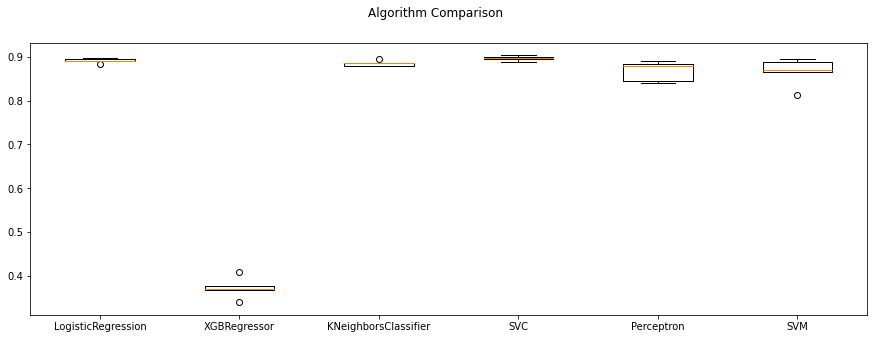

LogisticRegression => 89.08893742409686
XGBRegressor => 37.30138352824139
KNeighborsClassifier => 88.48061253893988
SVC => 89.64654114402354
Perceptron => 86.69402992861792
SVM => 86.58031466547229


In [39]:
# boxplot algorithm comparison
fig = plt.figure(figsize=[15,5])
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
for i in range(len(names)):
    print(names[i], "=>", results[i].mean()*100)

## en effectuant une cross validation,nous pouvons voir que le model "SVC", à le meilleur score avec un ecrat type très faible 

### grâce la méthode gridSearchcv , nous allons améliorer le score du model SVC

In [40]:
param_grid = {
    "kernel": ['linear', 'poly', 'rbf'],
    "gamma": ['scale', 'auto'],
    "verbose":[False, True],
}

grid = GridSearchCV(sklearn.svm.SVC(),param_grid,cv = 5 )
grid.fit(x_train, y_train)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

0.8964654114402354

In [43]:
# avec le GridSearchCV, nous obtenons le même resultat
grid.best_score_*100

89.64654114402354